<center>
    <h1 style="color:blue">
        <b>
            <u> PYTHON PROJECT </u>
        </b>
    </h1>
    <p>
        Auteur : KIVARKIS David - EL REAIDY Maria - SAHAKIAN Marc Antonio
    </p>
</center>

# Introduction

Within the realm of real estate, accurately predicting house prices is a challenge of both practical and financial significance. This project is centered on the development of a predictive model for house prices, leveraging the tools and techniques of data science. It aims to unravel the intricate relationships between various characteristics of a house, such as its size, number of bedrooms, and more, in order to provide insights into how these factors collectively impact its market value. Through this endeavor, we delve into the complex world of real estate valuation, seeking to understand the intricate interplay of variables that shape one of the most substantial financial decisions for homeowners and investors - the buying and selling of houses.

Let us start by importing the packages we are going to use.

In [10]:
import pandas as pd
import numpy as np
import matplotlib as plt

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from src.data_processing.load_data import load_data
from src.data_processing.data_processing_functions import *
from src.data_processing.NA_treatment import NA_treatment
from src.data_science.data import *
from src.figures.plot_performance import *
from src.figures.plot_figures import *

from config.config import TEST_RATIO, SEED

## Loading the data

In [2]:
# importing the dataset
data = load_data('data/house_prices.csv')

data.head()

,price,AreA,bedrooms,BATHROOMS,stories,mainroad,guestroom,basement,hotwaterheating,air conditioning,parking,prefarea,furnishing STATUS,houSeaGe
0,4543000.0,4990.0,4.0,2.0,2.0,yes,yes,yes,no,no,0.0,yes,furnished,15.0
1,8080940.0,7000.0,3.0,2.0,4.0,yes,no,no,no,yes,2.0,no,FURNISHED,11.0
2,8750000.0,4321.0,3.0,2.0,2.0,yes,no,yes,yes,no,2.0,no,FURNISHED,NaN
3,1890000.0,1700.0,3.0,1.0,2.0,yes,no,no,no,no,0.0,no,unfurnished,NaN
4,12215000.0,7500.0,4.0,2.0,2.0,yes,no,yes,no,yes,3.0,yes,furnished,NaN


# Data Exploration

After importing our data, we need to make sure that our data is well-formatted, standardized, and cleansed of any inconsistencies or anomalies. This involves meticulous data preprocessing tasks, including but not limited to handling missing values, addressing outliers, and converting variables into a consistent format. The goal is to create a dataset that is conducive to accurate analysis, allowing us to extract meaningful insights and draw reliable conclusions. Data quality at this stage is important, setting the foundation for robust exploratory data analysis and subsequent modeling endeavors.

## Data Formatting

We will start with implementing proper naming conventions for columns and ensuring uniformity in values that are represented differently.

In [3]:
# renaming the columns
data.columns = ["price", "area", "bedrooms", "bathrooms", "stories", "mainroad",
                "guestroom", "basement", "hot_water_heating", "air_conditioning",
                "parking", "pref_area", "furnishing_status", "house_age"]

print(data["furnishing_status"].unique())
# to lower case the values of furnishing_status column:
data["furnishing_status"] = data["furnishing_status"].str.lower()

# identifying how many non-null values we have in each column
data.info()

['furnished' 'FURNISHED' 'unfurnished' 'semi-furnished' nan 'Furnished']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              789 non-null    float64
 1   area               794 non-null    float64
 2   bedrooms           785 non-null    float64
 3   bathrooms          788 non-null    float64
 4   stories            794 non-null    float64
 5   mainroad           793 non-null    object 
 6   guestroom          786 non-null    object 
 7   basement           787 non-null    object 
 8   hot_water_heating  791 non-null    object 
 9   air_conditioning   794 non-null    object 
 10  parking            793 non-null    float64
 11  pref_area          795 non-null    object 
 12  furnishing_status  786 non-null    object 
 13  house_age          5 non-null      float64
dtypes: float64(7), object(7)
memory usage: 88.6+ KB


Then, we will encode our binary data to facilitate the training of the machine learning models that we will implement later on.

In [4]:
data = encoding_2_num(data)
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hot_water_heating,air_conditioning,parking,pref_area,furnishing_status,house_age
0,4543000.0,4990.0,4.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,15.0
1,8080940.0,7000.0,3.0,2.0,4.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,11.0
2,8750000.0,4321.0,3.0,2.0,2.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,2.0,NaN
3,1890000.0,1700.0,3.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,12215000.0,7500.0,4.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,3.0,1.0,2.0,NaN


## NA Treatment

Dealing with missing values is a common challenge in data analysis and machine learning, as they introduce complexity when attempting to extract meaningful insights or construct accurate models from a dataset. Effectively addressing these gaps in the data is essential for robust analyses and model development. 
For our data we first deleted the house_age column because it is mostly NA and has only 5 non-null values, and we removed the rows where the price (our target variable) where NA. Then, after looking at the database we noticed that if we sorted the rows by ascending price we have similar features for the same price so we thought of applying forward fill to fill the missing values. But to make sure what we are doing is not interfering with the real dependencies and relations between the features we decided to make a correlation heatmap to visualise the correlation matrix between the variables before and after dealing with the missing values. We combined all of this in a function called NA_treatment and we applied it to our dataset.

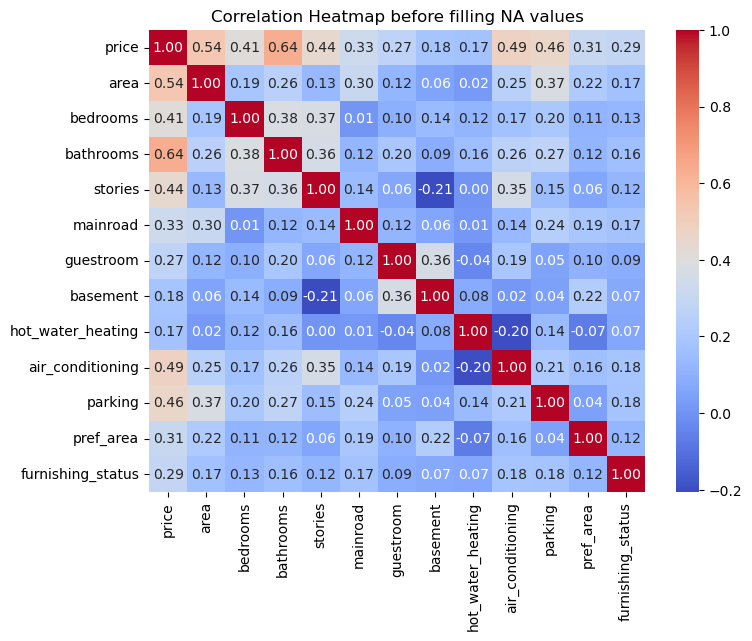

C:\Users\User\PPD\PPD\src\data_processing\NA_treatment.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data2 = data2.fillna(method='ffill')


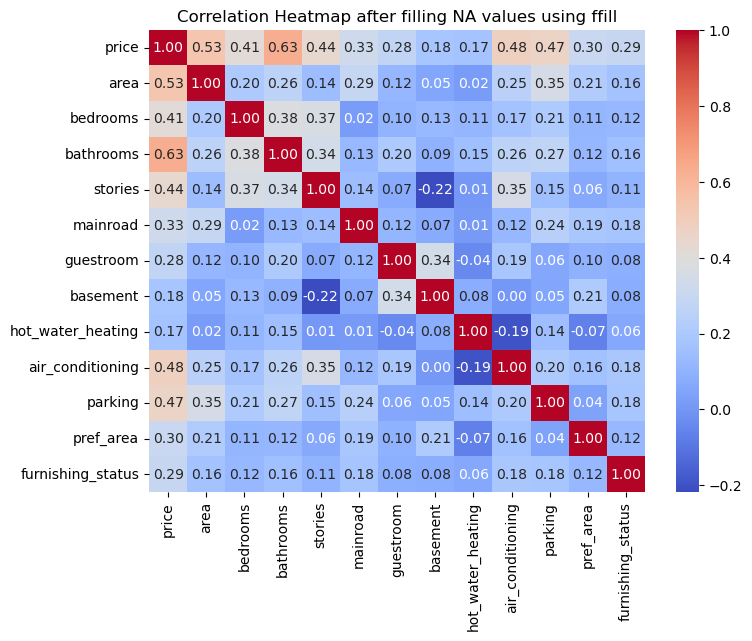

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hot_water_heating,air_conditioning,parking,pref_area,furnishing_status
538,13300000.0,7420.0,4.0,2.0,3.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0
762,13300000.0,7420.0,4.0,2.0,3.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0
723,12250000.0,8960.0,4.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,2.0
335,12250000.0,9960.0,3.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0
4,12215000.0,7500.0,4.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,3.0,1.0,2.0


In [5]:
data2 = NA_treatment(data)
data2.head()

As you can see above, the correlation has not changed much between the variables so our treatment will not have a negative impact on the machine learning process, and we can go on with our work. 

## Data Visualisation

Data visualization is an important facet of exploratory data analysis, offering a means to distill complex datasets into accessible, graphical forms. One of the primary objectives of data visualization is to provide a perceptually effective representation, minimizing cognitive load while maximizing information transfer. First we will make a univariate analysis and then a bivariate analysis.

### Univariate analysis
For the univariate analysis, we decided to visualise our data using barplots and boxpots.

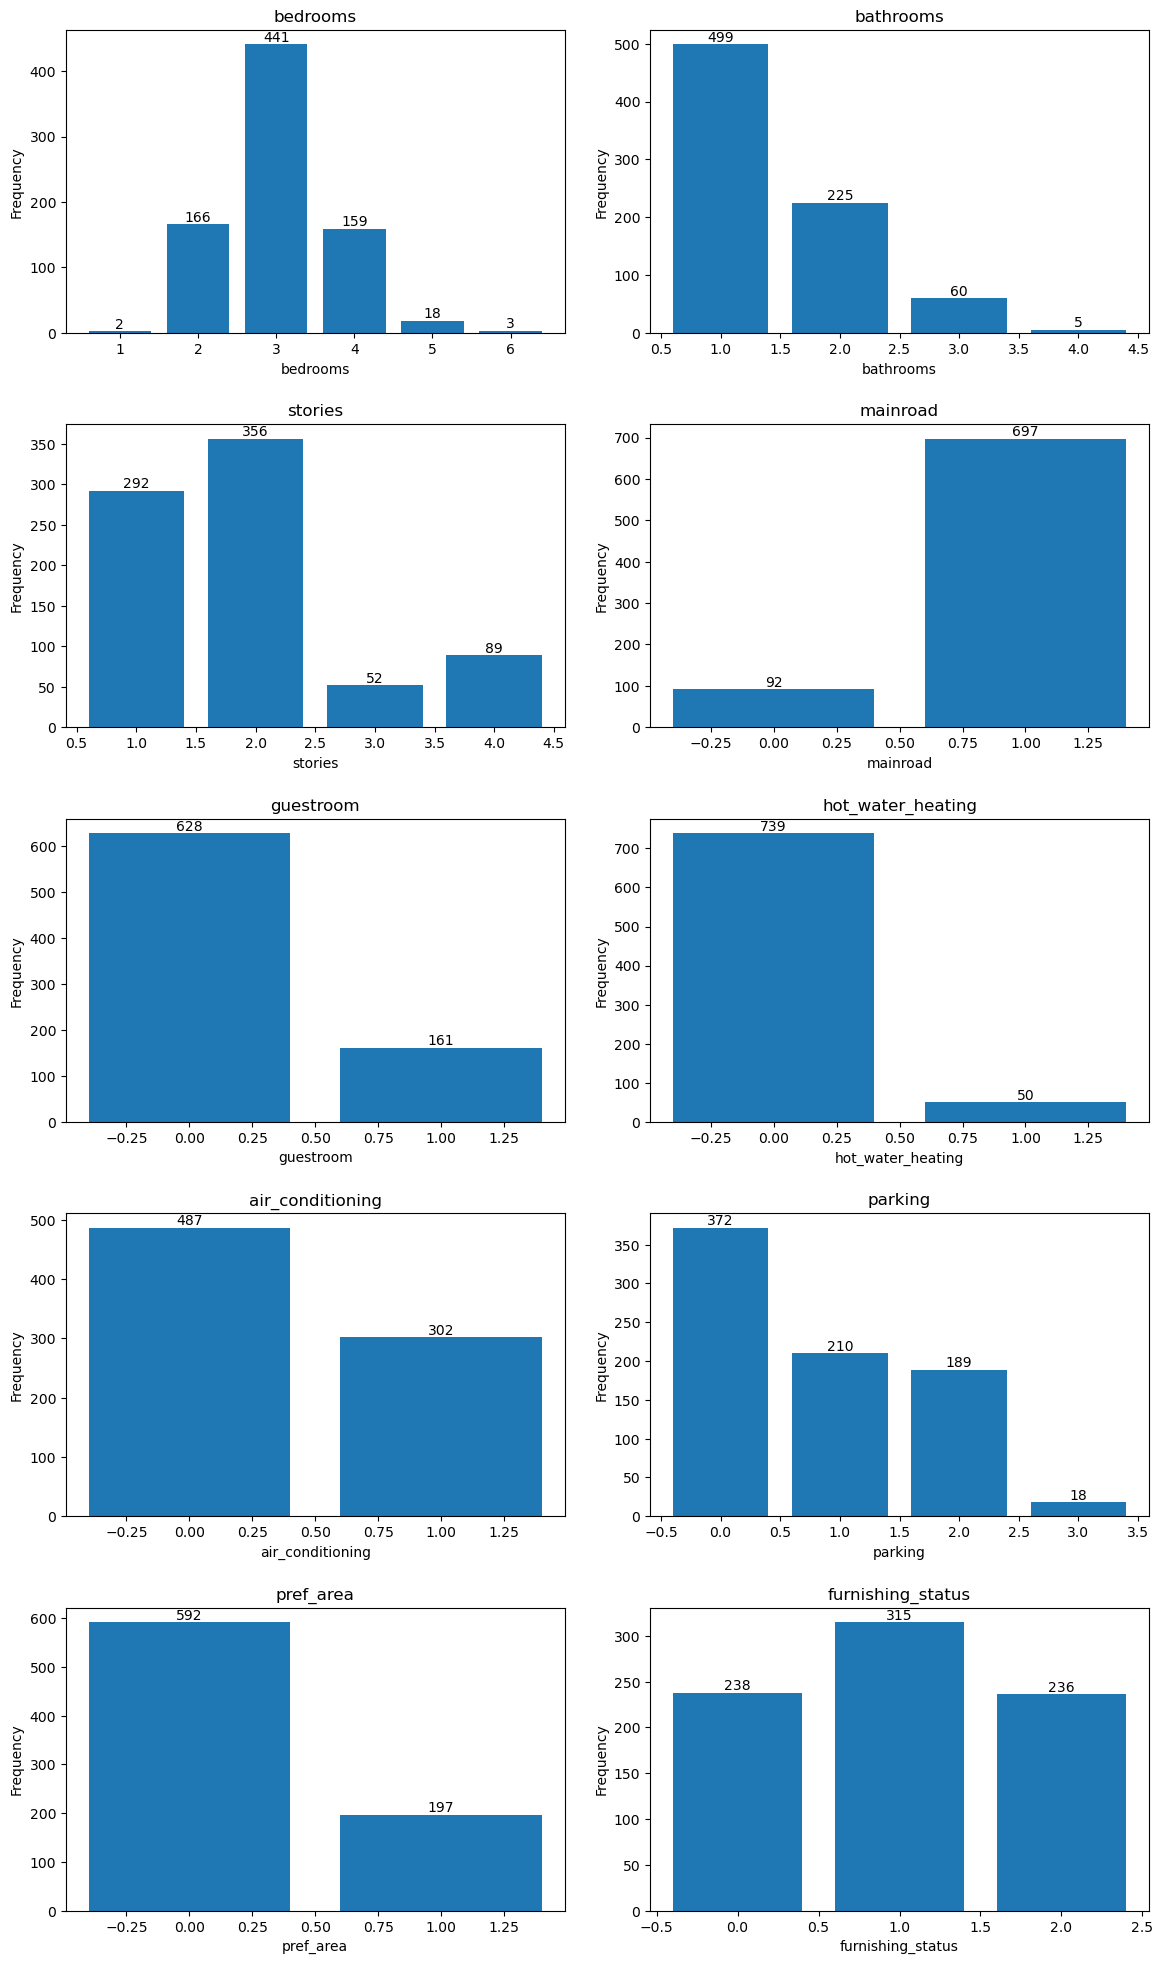

In [6]:
univariate_plot(data2, ['bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'hot_water_heating',
                        'air_conditioning', 'parking', 'pref_area', 'furnishing_status'])

The housing data reveals interesting insights about the residential landscape. A significant portion, 57%, features three bedrooms, while around 20-21% encompasses two and four-bedroom homes. Uncommonly, less than 2% of houses are equipped with 1, 5, and 5 bedrooms. In terms of bathrooms, 58% of residences possess a lone bathroom, whereas 29% boast two bathrooms. A scarce few, less than 7%, exhibit three bathrooms, and a mere five houses lay claim to four bathrooms.

Diverse in structure, 46% of homes stand as two-story structures, while 37% are single-story dwellings. The rarest category, constituting less than 7%, includes three and four-story houses. Accessibility seems a priority, with 90% of houses positioned along main roads, yet only a quarter are situated in preferred areas.

Additional features vary; a guestroom is found in only 29% of houses, while 33% house a basement. Surprisingly, a mere 6% incorporate water heating, and 37% are equipped with air conditioning.

Parking facilities are distributed with 48% lacking any spots, 27% offering one, and 24% providing two. A minuscule percentage, less than 2%, offer three parking spots. Lastly, only a quarter of houses are located in preferred areas, showcasing the diversity in residential choices. Furnishing availability also differs, with 29% fully furnished, 41% semi-furnished, and 31% lacking furnishings altogether.


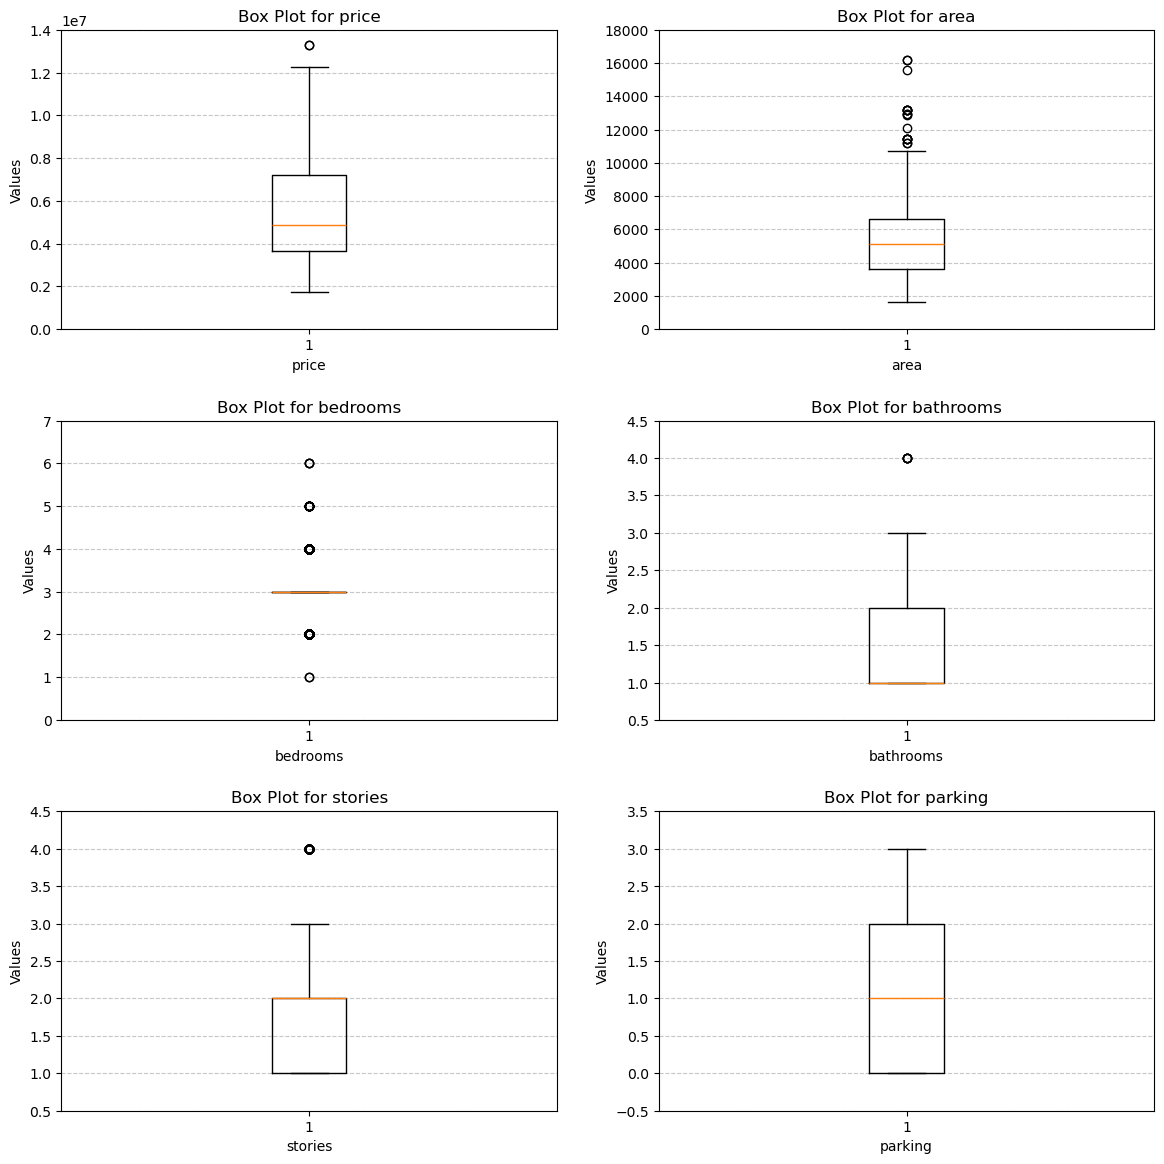

In [7]:
univariate_boxplots(data2)

The data distributions exhibit notable characteristics, revealing insights into various aspects of housing features. Positive skew is evident in the distributions of price, area and bathrooms. Conversely, a negative skew is observed in the distributions of stories. Bedrooms, however, demonstrates a normal distribution.

The housing market showcases a wide range of prices, with a maximum value reaching 12,000,000 and a minimum at 200,000. The majority of prices are concentrated between 400,000 and 800,000, reflecting a central tendency in this range. In terms of area, the data spans from 4,000m² to 6,500m², capturing the diversity in property sizes.

Common trends emerge among houses, with a prevalent configuration featuring 3 bedrooms, 1 bathroom and 2 stories.

### Multivariate analysis

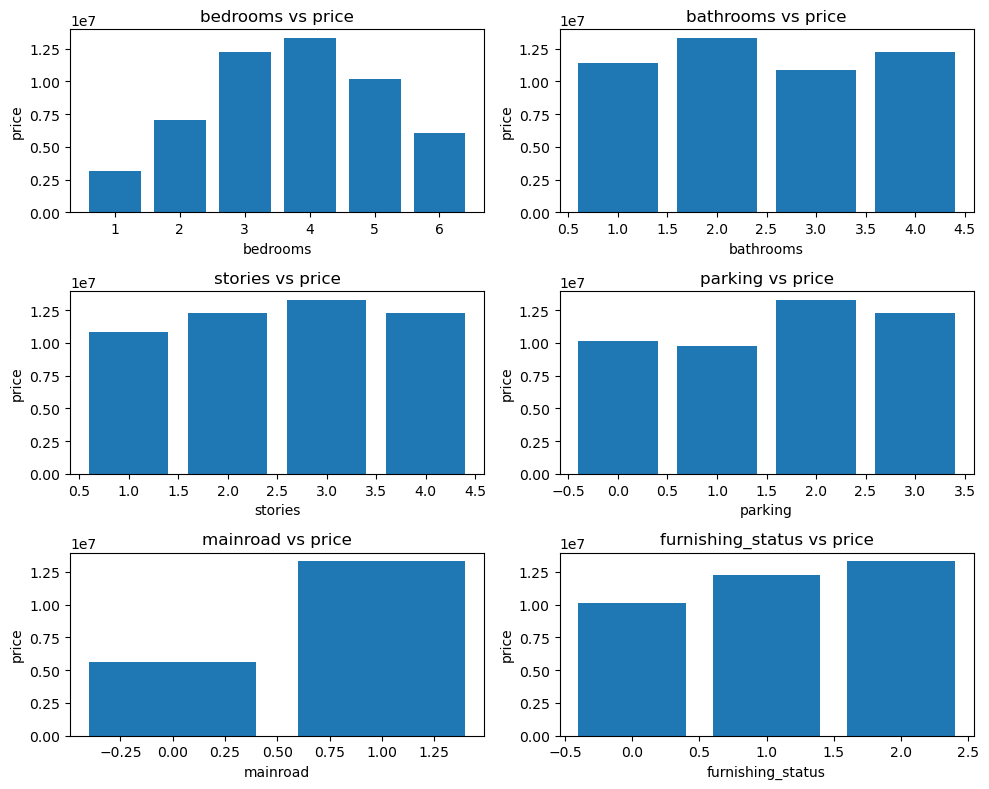

In [8]:
l = ["bedrooms", "bathrooms", "stories", "parking", "mainroad", "furnishing_status"]
bivariate_plot(data2, l)

Several discernible trends emerge when examining the relationship between various house features and their corresponding prices. As the number of bedrooms increases up to 4, there is a concurrent increase in the price of the house, indicating a positive correlation between bedroom count and property value. Expensive houses, characterized by higher price tags, tend to have either 2 or 4 bathrooms, showcasing a preference for well-appointed and spacious living arrangements.

Additionally, the price of a house is positively influenced by the number of stories it encompasses, with a notable increase in value as the number of stories rises. Houses with higher price points also exhibit a tendency to offer 2 to 3 parking spots, emphasizing the importance of parking convenience in the valuation of a property.

The location factor plays a significant role, as houses situated on the main road command higher prices. This underscores the desirability and potential accessibility associated with properties located in prominent or easily accessible areas.

Furthermore, there is a clear correlation between the level of furnishing and the price of the house. Expensive houses are more likely to be fully furnished, suggesting that a well-appointed interior contributes to the overall value of the property. Combining these features, the most expensive houses tend to have 4 bedrooms, 2 bathrooms, 3 stories, 2 parking slots, and are fully furnished, often positioned on the main road. These insights offer valuable considerations for both buyers and sellers in understanding the factors that influence housing prices in the real estate market.

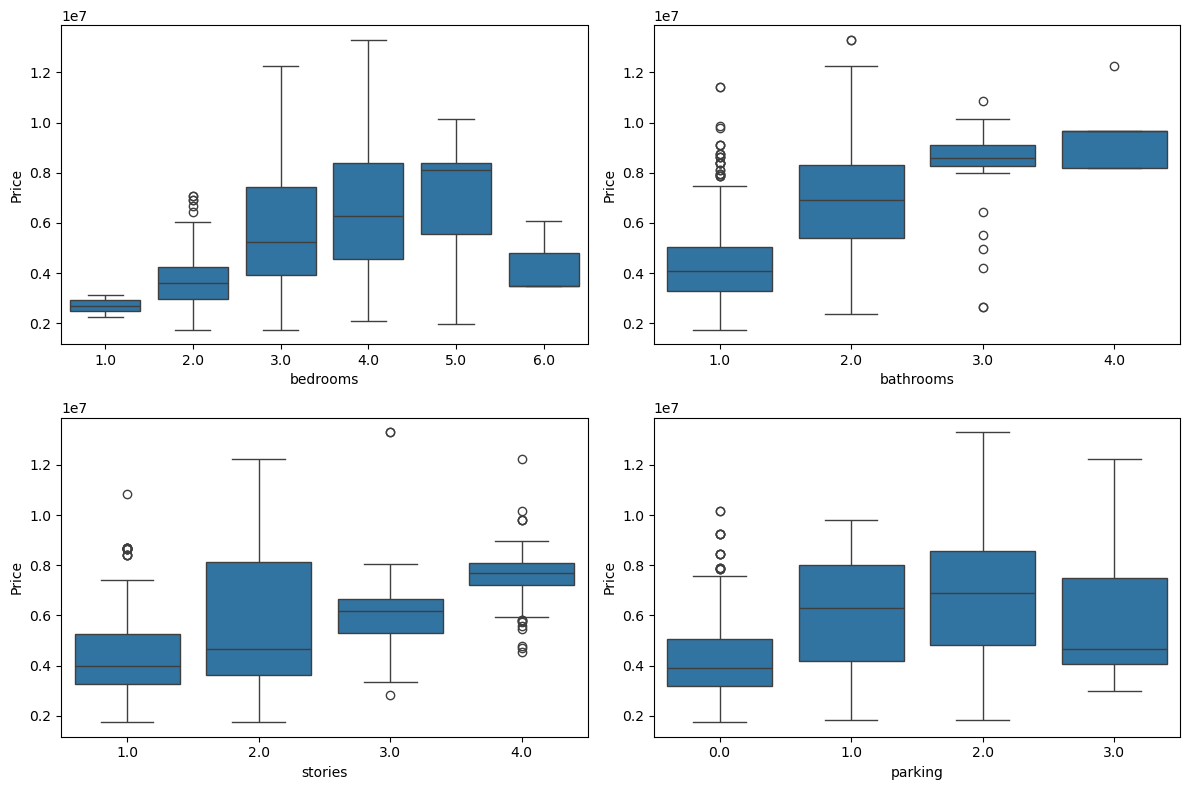

In [11]:
bivariate_boxplot(data2, ["bedrooms", "bathrooms", "stories", "parking"])

Distinct patterns emerge in the relationship between house prices and various features. In the price range of 400,000 to 800,000, houses commonly feature 3, 4, or 5 bedrooms, indicating a preference for larger residences within this bracket. Conversely, houses priced below 400,000 predominantly have 1, 2, or 6 bedrooms, emphasizing a trend towards smaller or more budget-friendly options in this lower price range.

Bathroom distribution aligns with price segments as well. Houses within the 300,000 to 500,000 range typically have 1 bathroom, while those in the 500,000 to 850,000 range tend to offer 2 bathrooms. Houses priced above 850,000 commonly feature 3 or 4 bathrooms, reflecting an increased preference for more amenities in higher-priced properties.

The correlation between the number of stories and price becomes apparent, with the majority of houses in the 400,000 to 800,000 range having 2 stories. Generally, higher numbers of stories correspond to higher prices, indicating that multi-story residences are valued more substantially.

Furthermore, a noteworthy observation is that houses with 2 parking spots tend to command higher prices. This suggests that parking facilities play a role in influencing property values, possibly due to increased convenience and desirability associated with ample parking spaces. These insights provide valuable information for both buyers and sellers in understanding the dynamics of the housing market.

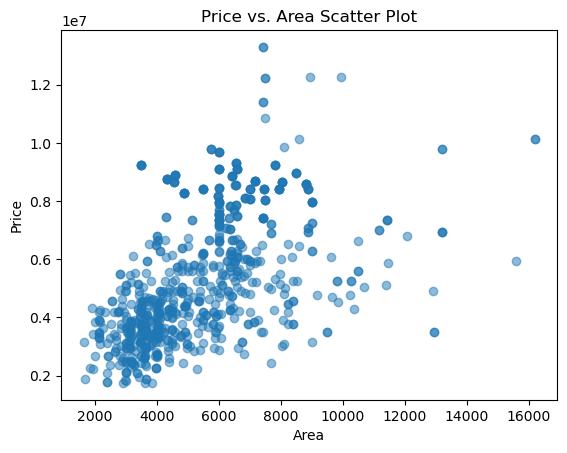

In [10]:
scatter_plot(data2, 'area', 'price', 'Price vs. Area Scatter Plot', 'Area', 'Price')

The prevailing trend in house sizes suggests that the majority falls within the area range of 2000m² to 8000m². Notably, there exists a positive correlation between the size of the house and its price. Larger houses tend to command higher prices in the housing market, reflecting the intrinsic value placed on increased living space and property size. This insight underscores the significance of the property's physical footprint as a determining factor in its overall market value. As such, buyers and sellers alike may consider this correlation when assessing and establishing property values in the real estate landscape.

# Cross Validation

The principle of cross-validation allows for self-estimation of the predictive performance of a function based on the available data.
The protocol involves dividing the labeled data into two sets, forming a partition, a training set and a test set, training the model on the training set, and estimating the performance on the test set.
This way, the data used to estimate performance consists of new examples that were not used during the learning process.

In [11]:
# VALIDATION CROISEE
X_train, X_test, y_train, y_test = split_data(data2, TEST_RATIO, SEED)

print(X_train.shape)
print(X_test.shape)

(631, 12)
(141, 12)


# Machine Learning

In this section, we are going to implement several machine learning protocoles following a progressive approach, starting from a baseline model to more sophisticated ones. 

## Baseline Model
We will first start with a baseline model that determines the mean house price depending on the number of rooms in the house.

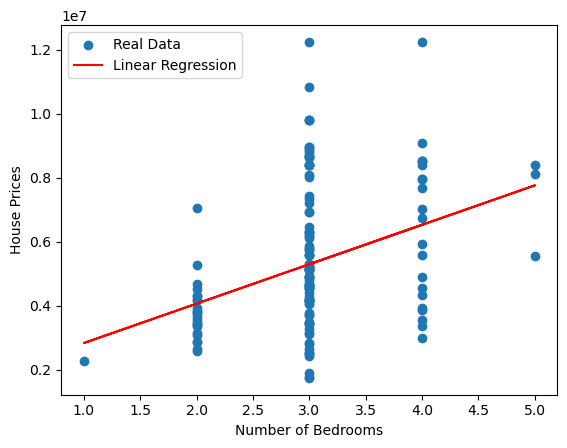

In [12]:
# Create a linear regression model
modele_baseline = LinearRegression()

# Adapte the model to the data
modele_baseline.fit(X_train['bedrooms'].values.reshape(-1, 1), y_train)

# Predict the house price depending on the number of bedrooms
y_pred = modele_baseline.predict(X_test['bedrooms'].values.reshape(-1, 1))

# Plot the regression line
plt.scatter(X_test['bedrooms'], y_test, label='Real Data')
plt.plot(X_test['bedrooms'], y_pred, label='Linear Regression', color='red')
plt.xlabel('Number of Bedrooms')
plt.ylabel('House Prices')
plt.legend()
plt.show()

As we can see in the representation the linear regression line does not fit the data very well it is not a good idea to predict the price based on the number of bedrooms only. But for further analysis we are going to compute the errors of this linear regression and plot the predictions against the actual values.

In [13]:
# Evaluate model performance
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-squared:', modele_baseline.score(X_test['bedrooms'].values.reshape(-1, 1), y_test))

Mean Absolute Error: 1608376.4916376
Mean Squared Error: 4353855576565.022
Root Mean Squared Error: 2086589.460474921
R-squared: 0.13671002017363076


The error of this model is huge and the R-squared is very small which confirms what we said earlier, this is not a good model. 

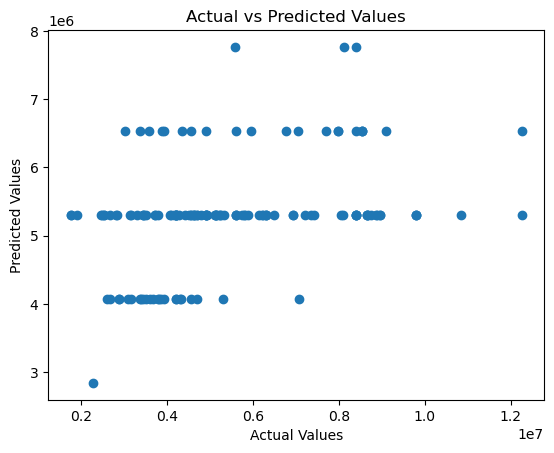

In [14]:
# Visualize the predictions against the actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

Furthermore, in an ideal scenario, where predictions perfectly match actual values, all data points would fall on a diagonal line (y = x) in the predictions against the actual values plot, but our model is not even close to a diagonal line.

### Data normalisation 

Data normalization is a data preprocessing operation that aims to scale all quantitative variables on the same scale. Normalizing features can help algorithms converge more quickly during training and can improve algorithm performance. There are different types of normalization, and we have used standardization. The purpose of this transformation is to bring the mean μ to 0 and the standard deviation σ to 1. Subtracting the mean helps remove any bias from the original data, and scaling to unit variance ensures that all features are on the same scale. In addition, the ensemblist model gradientboosting uses an optimization algorithm (gradient descent), that converges faster when the features are on a similar scale.

In [15]:
# Data Normalization
scaler = StandardScaler()
scaler_data = scaler.fit_transform(data2)

scaler_data = pd.DataFrame(scaler_data, columns=data2.columns)

X = scaler_data.drop("price", axis=1)
y = scaler_data["price"]

# seeing the mean equal to 0 and the standard deviation equal to 1.
X.describe()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hot_water_heating,air_conditioning,parking,pref_area,furnishing_status
count,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,789.000000,7.890000e+02,7.890000e+02
mean,-2.161347e-16,2.881796e-16,1.440898e-16,7.204489e-17,-7.204489e-17,7.204489e-17,-3.602245e-17,-6.303928e-17,-7.204489e-17,0.000000,-3.602245e-17,5.403367e-17
std,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634,1.000634e+00,1.000634e+00
min,-1.722272e+00,-2.765810e+00,-6.892683e-01,-9.816655e-01,-2.752469e+00,-5.063294e-01,-7.416861e-01,-2.601134e-01,-7.874790e-01,-0.928751,-5.768624e-01,-1.286914e+00
25%,-8.168473e-01,-5.833595e-02,-6.892683e-01,-9.816655e-01,3.633101e-01,-5.063294e-01,-7.416861e-01,-2.601134e-01,-7.874790e-01,-0.928751,-5.768624e-01,-1.286914e+00
50%,-1.373262e-01,-5.833595e-02,-6.892683e-01,8.371838e-02,3.633101e-01,-5.063294e-01,-7.416861e-01,-2.601134e-01,-7.874790e-01,0.212658,-5.768624e-01,3.270428e-03
75%,5.186539e-01,-5.833595e-02,8.213780e-01,8.371838e-02,3.633101e-01,-5.063294e-01,1.348279e+00,-2.601134e-01,1.269875e+00,1.354067,-5.768624e-01,1.293454e+00
max,4.864692e+00,4.002875e+00,3.842671e+00,2.214486e+00,3.633101e-01,1.974999e+00,1.348279e+00,3.844477e+00,1.269875e+00,2.495475,1.733516e+00,1.293454e+00


### Regression Models

To assess the importance of the amount of data in the learning phase, we created lists containing training and test data with different sizes. We then trained our models on various sizes and analyzed performance in the form of a graph depicting the performance for each training data size.

In [16]:
# Different size of training data
train_sizes = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Create empty lists to stock the data subsets
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Divide the data for each training size
for size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - size, random_state=SEED)
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)
    
print(len(X_train_list))

8


In [17]:
# The models we are going to work on at first:
models = [LinearRegression(), Ridge(), GradientBoostingRegressor()]  
model_names = [model.__class__.__name__ for model in models]

# Create lists to stock the performance of each model
models_mae_train_scores = {model.__class__.__name__: [] for model in models}
models_r2_train_scores = {model.__class__.__name__: [] for model in models}

models_mae_test_scores = {model.__class__.__name__: [] for model in models}
models_r2_test_scores = {model.__class__.__name__: [] for model in models}

# Create a dictionary to stock the coefficients of each model
coefficients_dict = {model.__class__.__name__: [] for model in models}

The parameters of the applied models are taken by default.

The metrics used to evaluate the models' performance are Mean Absolute Error (MAE) and R-squared.
MAE measures the average absolute error between the values predicted by the model and the actual (or target) values. It indicates how accurate the model is in terms of absolute error. A lower MAE indicates a more accurate model.

The R-squared score provides a performance indicator for the model. R-squared measures the proportion of the total variance of the dependent variable (target) explained by the model. It ranges from 0 to 1, where 0 means the model explains no variance, and 1 means the model explains all the variance. A high R-squared indicates that the model can explain a large portion of the data variability, while a low R-squared indicates that the model does not explain the data well.

Using the matplotlib library, we can compare the MAE (mean absolute error) of the models. We will do the same for R-squared.

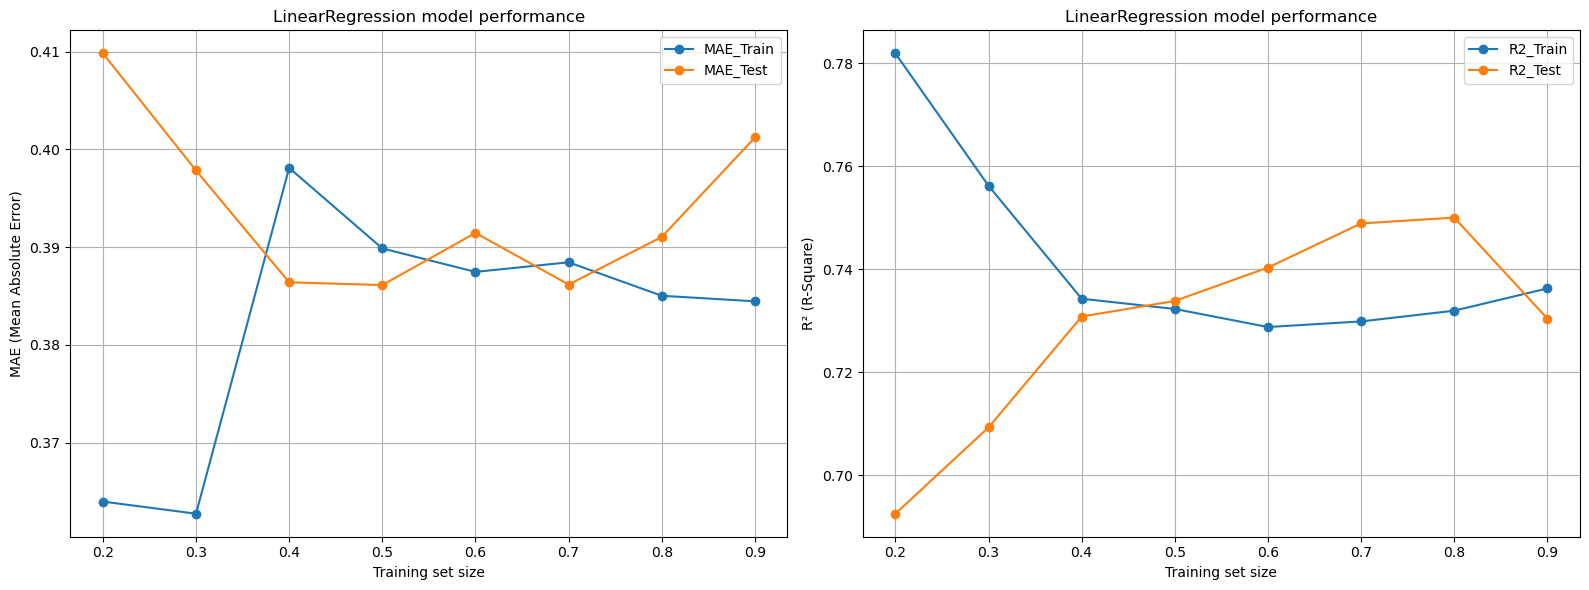

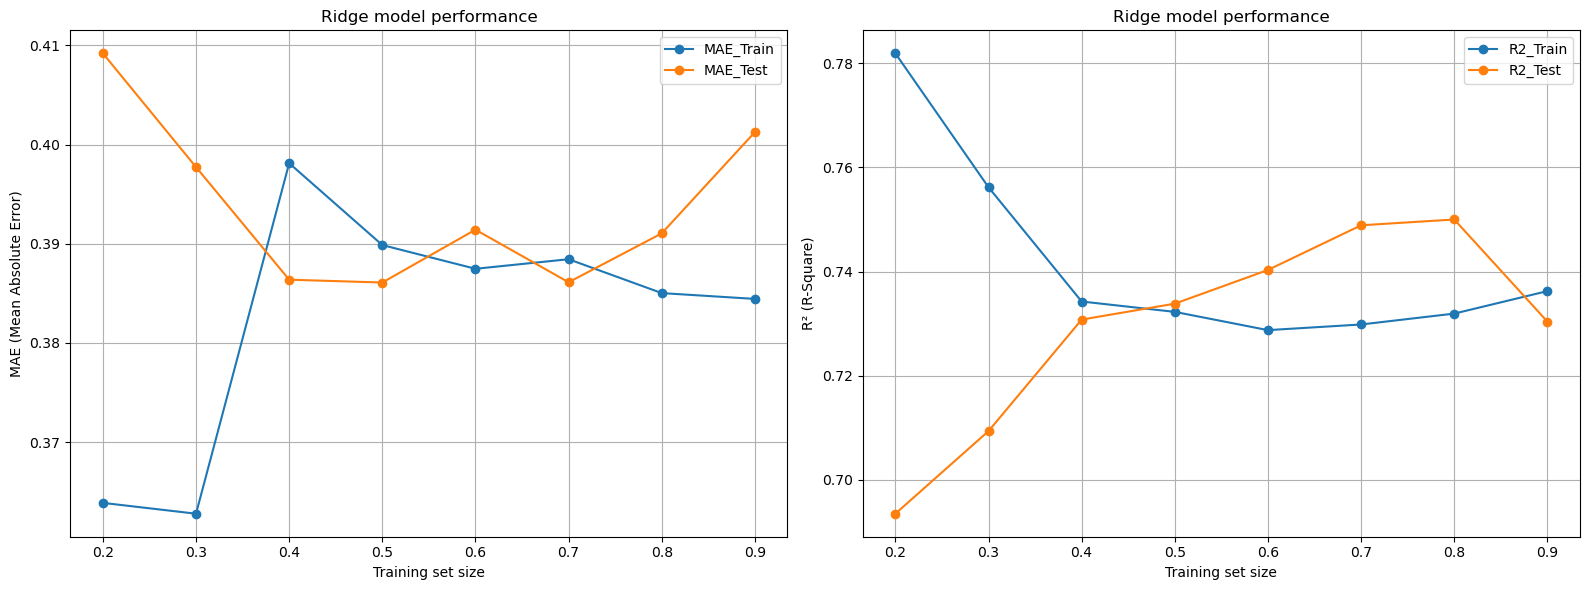

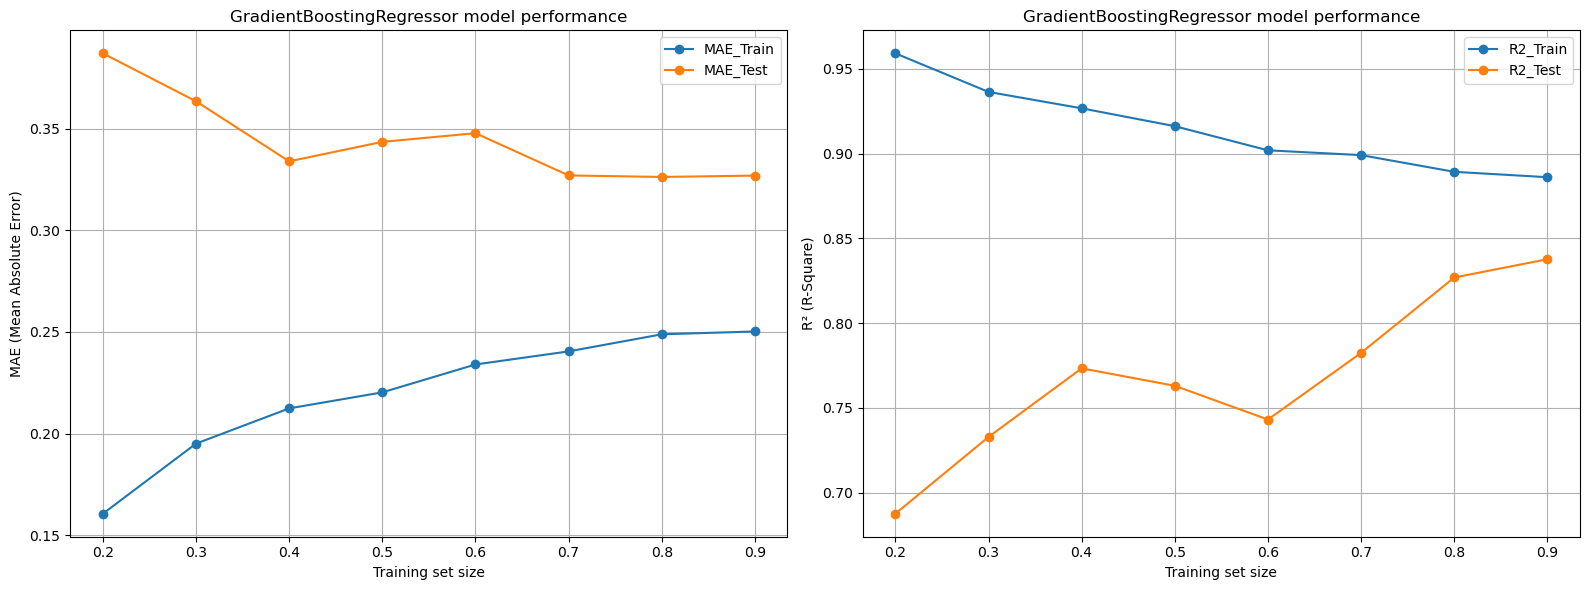

In [18]:
for model in models:
    for X_train, X_test, y_train, y_test in zip(X_train_list, X_test_list, y_train_list, y_test_list):
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict the values
        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)
        
        # Evaluate the model using the MAE
        mae_train = mean_absolute_error(y_train, train_predictions)
        mae_test = mean_absolute_error(y_test, test_predictions)
        
        # Evaluate the model using the R2  
        r2_train = r2_score(y_train, train_predictions)
        r2_test = r2_score(y_test, test_predictions)
        
        # Stock the MSE in the performance list
        models_mae_train_scores[model.__class__.__name__].append(mae_train)
        models_mae_test_scores[model.__class__.__name__].append(mae_test)
        models_r2_train_scores[model.__class__.__name__].append(r2_train)
        models_r2_test_scores[model.__class__.__name__].append(r2_test)
        
        # Extract the model's coefficients
        coefficients = model.coef_ if hasattr(model, 'coef_') else None
        coefficients_dict[model.__class__.__name__].append(coefficients)
        
    # Visualisation the performances (MAE / R_square)    
    plot_performance(train_sizes, model.__class__.__name__,
                     models_mae_train_scores[model.__class__.__name__],
                     models_mae_test_scores[model.__class__.__name__], 
                     models_r2_train_scores[model.__class__.__name__],
                     models_r2_test_scores[model.__class__.__name__])

For the linear model, we observe that the model had a small MAE on 20% of the training data. However, when we slightly increased the amount of data from 20%, the error abruptly increased before decreasing again after training with a higher number of X_train. On the test set, since the model was trained on a small amount of data (20% of the data), not sufficiently trained, it had a somewhat high MAE (0.41). The error then gradually decreased as more data (between 40% and 70% of the data) was provided. Finally, with 90% of the training data, the model overfit, resulting in more errors and an increasing MAE.

In the linear model, it is observed that for different sizes of training data, such as 40-50-70% of the dataset, the model makes fewer errors in testing than in training.
The more we train our linear model with a larger dataset, the lower its score becomes, which is logical because the linear model is not effective/appropriate for our dataset and its data types. Therefore, as the size of the test data decreases, the R-squared value increases.
For small training data (20-40%) and thus a large test dataset, we have lower test scores than in training. Then, when we take 50-80% of the data for training, the opposite occurs: test scores increase and become higher than the training scores.

We observe almost the same trends for the Ridge penalized regression.

For a small X_train size (20%), we have a low MAE (0.16), which is logical given the limited data. However, the X_test (data the model has never seen), which is large (size of X_test = size of the dataset - size of X_train), has a much higher error (0.38). As we increase our training data, the model makes more errors but shows fewer errors on the test data, which decreases in size each time X_train increases. For example, with 70% of the training data, we have a MAE of 0.24 and 0.32 on X_test.

Concerning the R-squared score, indicating the model's performance, for a small X_train, we have a high score since it has not made many errors, while on X_test, we have a much lower score. As the training data increases, the R-squared decreases, but the opposite occurs on X_test, increasing as the test data decreases and the size of X_train increases.

We notice that the model's performance increases when the size of the training data is greater than the size of the test data, implying better generalization and a higher score.

### Linear regression coefficients

The analysis of coefficients is a crucial aspect of interpreting a linear regression model. It allows us to understand which factors positively or negatively influence the dependent variable (price) and to what extent.

It's noteworthy that the sign of the coefficient indicates the direction of the relationship between the corresponding independent variable and the dependent variable. If the coefficient is positive, it means that when the independent variable increases, the dependent variable (price) tends to increase as well, and vice versa.

Furthermore, the magnitude (absolute value) of the coefficient represents the importance of the independent variable in predicting the dependent variable. The larger the coefficient in absolute value, the more significant the impact of the variable on the prediction.

As its name suggests, coefficients_lin_reg_df is a dataframe containing the regression coefficients for different sizes of X_train.

In [19]:
# Transform the dictionary to a DataFrame
coefficients_df = pd.DataFrame(coefficients_dict)

# Extract the coefficients for the linear regression
coefficients_lin_reg_df = pd.DataFrame(coefficients_dict["LinearRegression"])

# Rename the columns of coefficients_lin_reg_df to match the column names of X
coefficients_lin_reg_df = coefficients_lin_reg_df.rename(columns=dict(zip(coefficients_lin_reg_df.columns, X.columns)))

In [20]:
print(coefficients_lin_reg_df)

       area  bedrooms  bathrooms   stories  mainroad  guestroom  basement  \
0  0.340500 -0.018948   0.342293  0.189127  0.015925   0.104707  0.107578   
1  0.265575  0.003102   0.319400  0.192814  0.066315   0.079199  0.092727   
2  0.248783  0.057699   0.276078  0.181620  0.066205   0.110122  0.103084   
3  0.242657  0.059999   0.298884  0.174664  0.069308   0.110224  0.079643   
4  0.221608  0.059053   0.290149  0.177743  0.075146   0.086168  0.082258   
5  0.222585  0.067550   0.304674  0.173122  0.075039   0.069513  0.083351   
6  0.229346  0.067146   0.318291  0.158626  0.075736   0.072180  0.064411   
7  0.231082  0.068345   0.316908  0.160997  0.076741   0.074535  0.063589   

   hot_water_heating  air_conditioning   parking  pref_area  furnishing_status  
0           0.099498          0.184708  0.089966   0.137382           0.018582  
1           0.068942          0.216739  0.091112   0.113225           0.059395  
2           0.111885          0.204785  0.160764   0.110785    

The variables area, bathrooms, stories, air_conditioning, and parking contribute the most to predicting the dependent variable (price). The positive signs of these coefficients indicate that as the area of a house increases, the price tends to increase.
The same applies to the bathrooms, stories, parking, and air conditioning variables, as the number of bathrooms, stories, and parking spaces increase, the price tends to rise. 
In other words, these features have a positive impact on house prices, which aligns with intuitive expectations.

### Comparing the models

Thanks to the Matplotlib library, we can compare the Mean Absolute Error (MAE) of the models. We will then perform the same comparison for R-squared values.

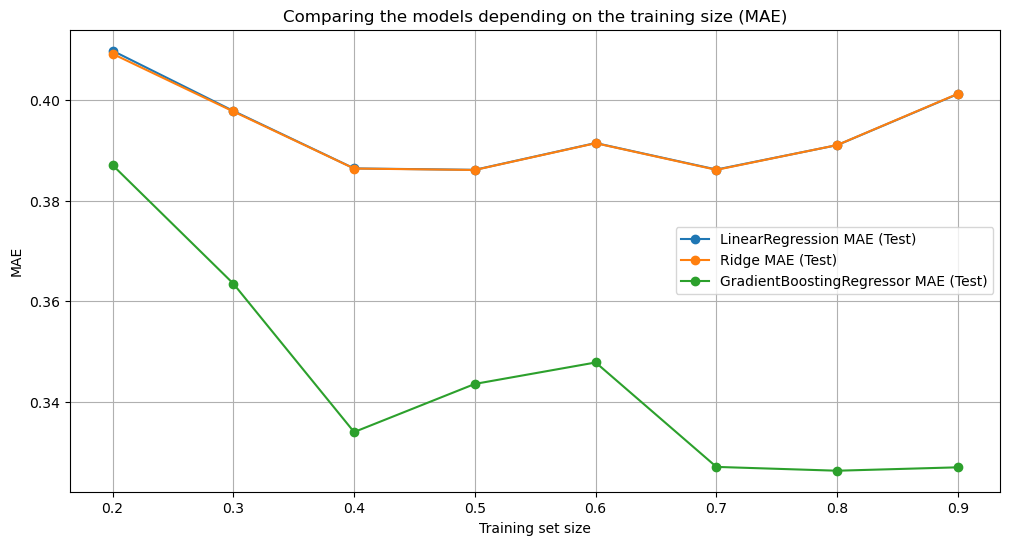

In [21]:
# Create a graph for the MAE for the train and test data
plt.figure(figsize=(12, 6))
for model_name in model_names:
    plt.plot(train_sizes, models_mae_test_scores[model_name], marker='o', linestyle='-', label=f"{model_name} MAE (Test)")
    
plt.xlabel("Training set size")
plt.ylabel("MAE")
plt.title("Comparing the models depending on the training size (MAE)")
plt.legend()
plt.grid(True)
plt.show()

The GradientBoosting model has the lowest MAE among these three models for all different training data sizes. This implies that, on average, its predictions are closer to the actual values than the predictions of the other models. In contrast, the errors of linear regression and Ridge regression which are confounded and higher, indicating less precision.

Therefore, we can conclude that GradientBoosting has the best performance among the three and can be considered the most accurate. 

However, let's also consider another indicator, which is the R-squared.

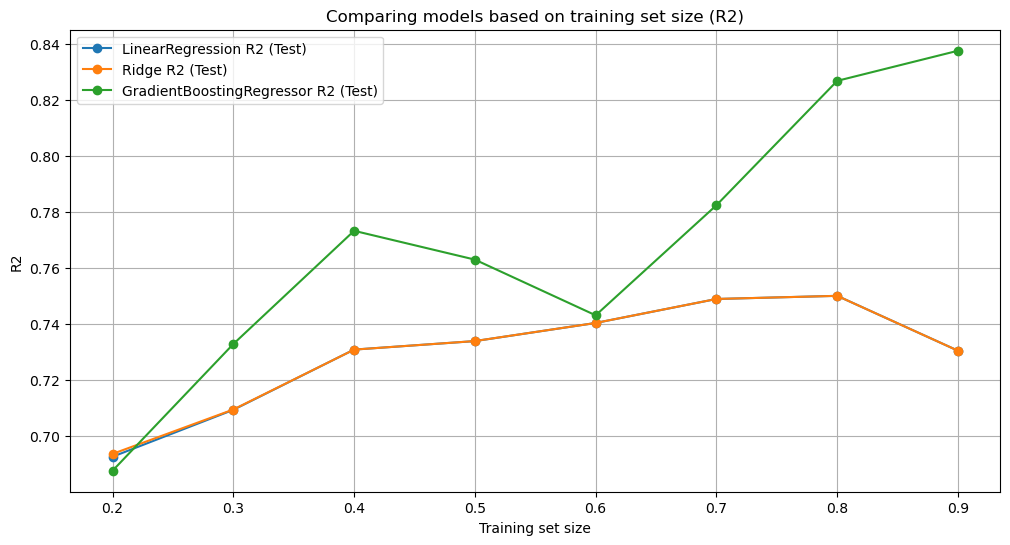

In [22]:
# Create a graph for R2 for the train and test data
plt.figure(figsize=(12, 6))
for model_name in model_names:
    plt.plot(train_sizes, models_r2_test_scores[model_name], marker='o', linestyle='-', label=f"{model_name} R2 (Test)")

plt.xlabel("Training set size")
plt.ylabel("R2")
plt.title("Comparing models based on training set size (R2)")
plt.legend()
plt.grid(True)
plt.show()

The R-squared score of GradientBoosting surpasses the scores of the other models across different training data sizes, except for 20%. This model, with the highest R-squared, exhibits the best performance among the three. This implies that the GradientBoosting model explains a larger portion of the variance in the data compared to the other models.

This indicates that GradientBoosting fits the data better and can make better predictions compared to the regression models.


## Random Forest Model

Random Forest is an ensemble machine learning algorithm that combines the predictions of multiple decision trees to make more accurate and robust predictions. Ensemble is a Machine Learning concept in which the idea is to combine multiples models to create a stronger and more accurate model. There are two types of random forest methods:
- Random forest regression: For predicting continuous outcome variables like salary, income, prices etc.
- Random forest classifier: For predicting a class label like Yes or No, active or lapsed, etc.

In our case, we will apply the first method for predicting house prices. Random forest takes several hyperparamters like `max_depth`, `number of estimators`, `max feaures`, `bootstrap`, and more. We will see the infuence of two hyperparameters (`max_depth` and `n_estimators`) on the model performance.

The parameter `max_features` in the RandomForestRegressor plays a crucial role in controlling the growth of the tree and model fitting. It determines the maximum number of features the model considers when searching for the best split at each node of the decision tree.

We have chosen to set `max_features` to 'sqrt' (square root). This means that the model will use the square root of the total number of features available in the dataset as the maximum number of features to consider for each split. This choice is made to reduce the correlation between the trees in the forest and can make each tree more independent, potentially improving the model's robustness. Taking the square root of the total number of features can also help limit overfitting by controlling the number of features considered during the tree-building process.

Decision trees are not concerned with the absolute scales of features but rather with the ordinal relationships between values. Separation conditions are typically based on thresholds, making decision trees inherently scale-invariant. This means that they can handle data at different scales without requiring prior normalization. In other words, the decision tree algorithm focuses on the hierarchy of relationships between feature values rather than the raw numerical values. This imparts a degree of robustness to decision trees regarding data with varying scales, eliminating the need to normalize features before using them in the model.

In [23]:
X_train, X_test, y_train, y_test = split_data(data2, TEST_RATIO, SEED)

# Max_depth parameter and its importance/impact :
max_depth_values = [3, 5, 7, 10, 12, 15, 20, 25, 30, 40]
                  
# Defining lists to store/save MSE and R_square score :
mae_train_scores = []
mse_train_scores = []
r2_train_scores = []

mae_test_scores = []
mse_test_scores = []
r2_test_scores = []

# Looping on different values Max_depth : 
for max_depth in max_depth_values:
    
    rf = RandomForestRegressor(n_estimators=200, max_features='sqrt',
                               max_depth=max_depth, random_state=SEED).fit(X_train, y_train)

    # MSE and MAE train
    train_predictions = rf.predict(X_train)
    mse_train = mean_squared_error(y_train, train_predictions)
    mse_train_scores.append(mse_train)
    mae_train = mean_absolute_error(y_train, train_predictions)
    mae_train_scores.append(mae_train)

    # MSE and MAE test 
    test_predictions = rf.predict(X_test)
    mse_test = mean_squared_error(y_test, test_predictions)
    mse_test_scores.append(mse_test)
    mae_test = mean_absolute_error(y_test, test_predictions)
    mae_test_scores.append(mae_test)
    
    # R_square score
    r2_train_scores.append(rf.score(X_train,y_train)) 
    r2_test_scores.append(rf.score(X_test,y_test)) 

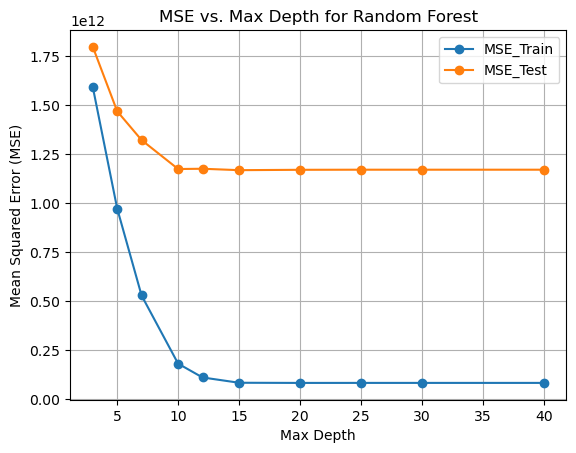

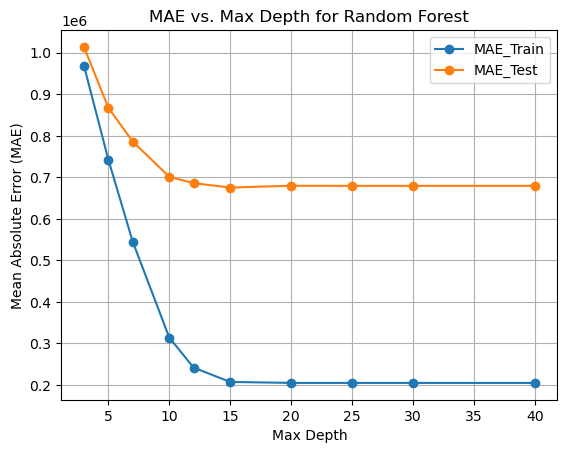

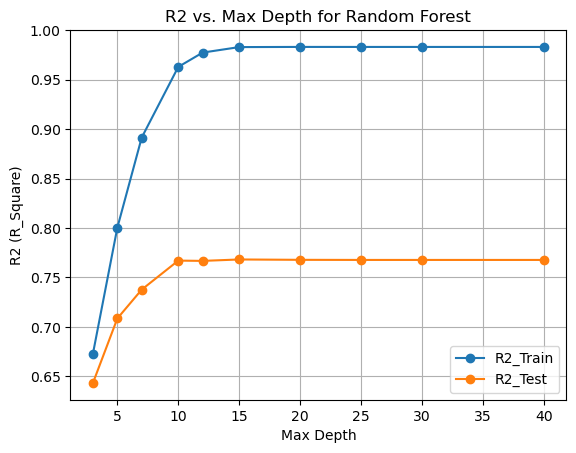

In [24]:
# Visualisation 

# Plotting MSE vs Max_depth
plot_mse_vs_max_depth(max_depth_values, mse_train_scores, mse_test_scores)

# Plotting MAE vs Max_depth
plot_mae_vs_max_depth(max_depth_values, mae_train_scores, mae_test_scores)

# Plotting R_square vs Max_depth
plot_r2_vs_max_depth(max_depth_values, r2_train_scores, r2_test_scores)

By visualizing the graph of mean absolute error against the tree depth, we can observe that initially, the training and test errors are close (for a depth equal to 3). We see that as the tree depth increases, the MAE decreases, both for training and test data. However, for the test data, the errors are larger than during training.

The score increases as the tree depth grows, with higher scores in training compared to testing. At a depth of 5, the model has a score of 0.80 during training and 0.71 during testing. For a depth of 12, the scores are 0.97 for training and 0.76 for testing.

In [25]:
# n_estimators parameter and its importance/impact
n_estimators_values = [50, 100, 150, 200, 250, 300, 350, 400 ]

# Defining lists to store/save MSE and R_square score :
mae_train_scores_n_estimators = []
mse_train_scores_n_estimators = []
r2_train_scores_n_estimators = []

mae_test_scores_n_estimators = []
mse_test_scores_n_estimators = []
r2_test_scores_n_estimators = []

# Looping on different values n_estimators : 
for n_estimator in n_estimators_values:

    rf = RandomForestRegressor(n_estimators=n_estimator, max_features='sqrt',
                               max_depth=20, random_state=SEED).fit(X_train, y_train)
    
    # MSE and MAE train
    train_predictions = rf.predict(X_train)
    mse_train = mean_squared_error(y_train, train_predictions)
    mse_train_scores_n_estimators.append(mse_train)
    mae_train = mean_absolute_error(y_train, train_predictions)
    mae_train_scores_n_estimators.append(mae_train)

    # MSE and MAE test 
    test_predictions = rf.predict(X_test)
    mse_test = mean_squared_error(y_test, test_predictions)
    mse_test_scores_n_estimators.append(mse_test)
    mae_test = mean_absolute_error(y_test, test_predictions)
    mae_test_scores_n_estimators.append(mae_test)
    
    # R_square score
    r2_train_scores_n_estimators.append(rf.score(X_train,y_train)) 
    r2_test_scores_n_estimators.append(rf.score(X_test,y_test))

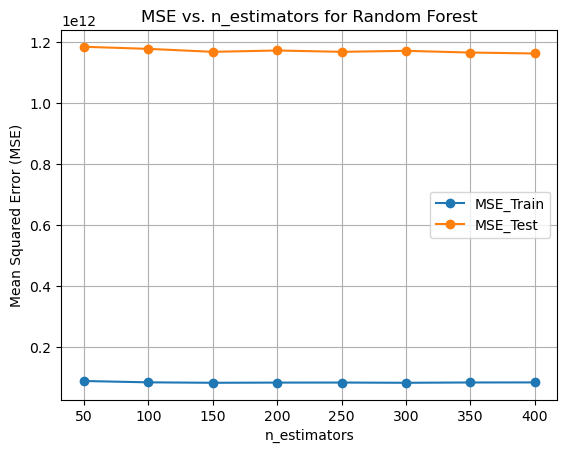

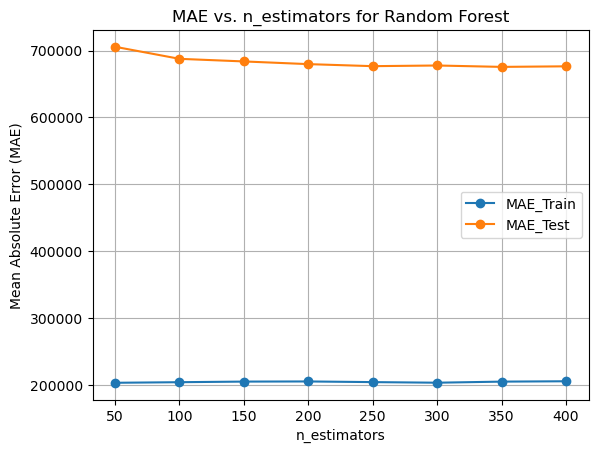

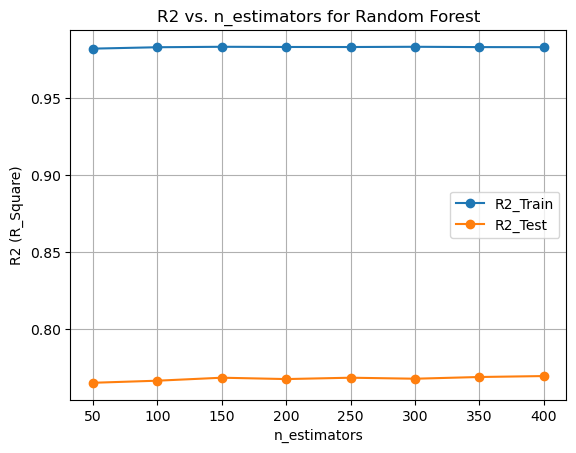

In [26]:
# Visualization of the performance of random forest depending on the number of estimators 

# Plotting MSE vs n_estimators
plot_mse_vs_n_estimators(n_estimators_values, mse_train_scores_n_estimators, mse_test_scores_n_estimators)

# Plotting MAE vs n_estimators
plot_mae_vs_n_estimators(n_estimators_values, mae_train_scores_n_estimators, mae_test_scores_n_estimators)

# Plotting R_square vs n_estimators
plot_r2_vs_n_estimators(n_estimators_values, r2_train_scores_n_estimators, r2_test_scores_n_estimators)

During the training of the model, there is a slight decrease in error initially when transitioning from 50 to 100 estimators, after which the error stabilizes more or less as the number of trees increases. However, the errors are much higher on the test data and remain elevated even when varying the number of estimators.

It is evident that the model exhibits perfect performance on the training data (0.98) regardless of the number of estimators in the model. However, the scores are lower on the test data (0.76). 

It can be concluded that the depth of the tree plays a more significant role in the model's performance than the number of estimators, as observed in the graphs.

### Grid search :


RandomizedSearchCV and GridSearchCV are two hyperparameter optimization techniques commonly used in machine learning.
In grid Search all possible permutations of the hyper parameters for a particular model are used to build models. The performance of each model is evaluated and the best performing one is selected. Since GridSearchCV uses each and every combination to build and evaluate the model performance, this method is highly computational expensive especially if the hyperparameter space is large.

In randomizedsearchcv, instead of providing a discrete set of values to explore on each hyperparameter, we provide a statistical distribution or list of hyper parameters. Values for the different hyper parameters are picked up at random from this distribution. RandomizedSearchCV is more time-efficient, as it tests a fixed number of hyperparameter combinations, making it a better choice when computation time is limited.

In our case, our dataset is small, so we've decided to use GridSearchCV. 

The variable `grid` contains the values to test for each hyperparameter of the model. The `estimator` parameter specifies the model we want to optimize. In this case, it is the RandomForestRegressor. In `param_grid`, we specify the grid of hyperparameters that we want to optimize. The `cv` parameter is the cross-validation we want to use. In this case, it is a 3-fold cross-validation, which means that the data will be divided into three parts, and the model will be trained on two parts and evaluated on the third, and this process will be repeated three times (once for each combination). We chose `cv = 3` and not a bigger number because we have a small dataset.

In [27]:
# Define Grid
grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 400],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 4, 5, 6, 7, 10, 15, 20],
    'random_state': [18]
}

# Grid Search function
grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv=3)

# Applying grid_search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 10, 15, 20],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [50, 100, 150, 200, 250, 300, 400],
                         'random_state': [18]})

In [28]:
# Obtaining the best parameters and estimators
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best parameter : ", best_params)
print("Best estimator : ", best_estimator)

Best parameter :  {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 50, 'random_state': 18}
Best estimator :  RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=50,
                      random_state=18)


Now that we got the best parameters using grid search, we are going to create a model using them.

In [29]:
# Model with the optimal parameters
rf_opt_param = RandomForestRegressor(n_estimators=50, max_features='sqrt',
                                       max_depth=20, random_state=SEED).fit(X_train, y_train)

train_prediction_opt = rf_opt_param.predict(X_train)
mae_train_opt = mean_absolute_error(y_train, train_prediction_opt)

test_prediction_opt = rf_opt_param.predict(X_test)
mae_test_opt = mean_absolute_error(y_test, test_prediction_opt)

r2_train = rf_opt_param.score(X_train, y_train)
r2_test = rf_opt_param.score(X_test, y_test)

In [30]:
print("MAE train : ", mae_train_opt)
print("MAE test : ", mae_test_opt)
print("R_square train : ", r2_train)
print("R_square test : ", r2_test)

MAE train :  202808.094241944
MAE test :  705589.9418439716
R_square train :  0.9819628144113638
R_square test :  0.7653760755948461


We can see that we got better results using the random forest with the best parameters that we got from gridsearch.

#### True Values vs Predicted Values
The "True Values vs. Predicted Values" plot for the RandomForestRegressor model is a visual tool to assess the model's performance in terms of predictions compared to actual values. The horizontal position of a point corresponds to the true value, while the vertical position corresponds to the value predicted by the model for that observation. A diagonal line at a 45-degree angle across the plot represents the ideal scenario where real and predicted values are equal. If the model predicts perfectly, all points would align along this line. The closer the points are grouped around the ideal line, the better the model's performance. Points deviating from the ideal line represent prediction errors made by the model. You can identify observations for which the model struggled to make accurate predictions.

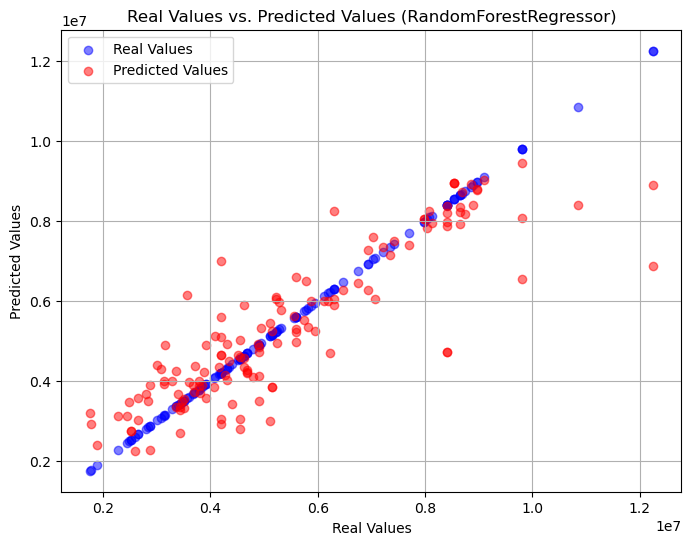

In [31]:
# Visualize the predictions against the actual values
scatter_plot_true_vs_predicted(y_test, test_prediction_opt, model_name="RandomForestRegressor")

#### Features importance :

The feature_importances_ function is used to assess the importance of each feature (variable) in the decision-making process of the model. Each feature receives an importance score, helping determine which features have the most influence on the model's predictions. Feature importance in an ensemble model (Random Forest in this case) is calculated based on each feature's contribution to reducing error (impurity) during the construction of the decision tree ensemble.

There are several methods to calculate feature importance in an ensemble model, and Random Forest generally uses one of two methods: importance based on the decrease in the Gini impurity index or importance based on the decrease in Mean Squared Error (MSE). To determine which measure of decrease the feature importance of our Random Forest model is based on (Gini impurity or MSE), we used the criterion attribute of the model. In this case, MSE is used. The higher the decrease in MSE due to a feature, the more important that feature is considered.

The calculation of feature importance occurs during the construction of each decision tree in the Random Forest ensemble. Subsequently, the importance scores are averaged over all the trees in the forest to obtain the final importance scores. Features that have a greater contribution to error reduction are considered more important.

The measure of decrease used :  squared_error


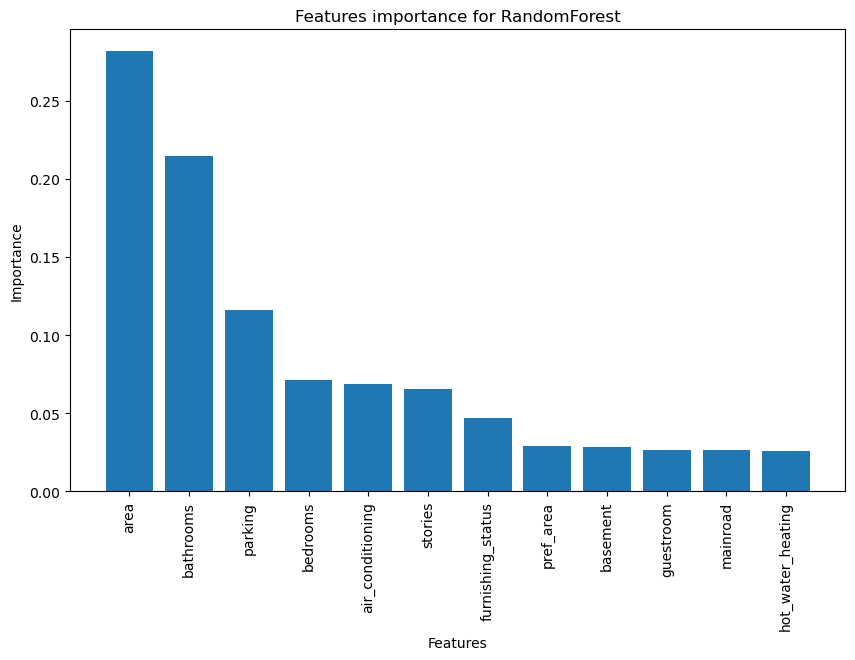

In [32]:
# We can see the feature importance of our random forest
features_importance = pd.DataFrame(rf_opt_param.feature_importances_,
                                  index=X_test.columns, 
                                  columns=["importance"]).sort_values("importance", ascending=False)

# Obtaining the measure of decrease 
criterion_used = rf_opt_param.criterion

print("The measure of decrease used : ", criterion_used)

# Create a barplot to show the importance of the fonctionnalities
plt.figure(figsize=(10, 6))
plt.bar(features_importance.index, features_importance['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Features importance for RandomForest')
plt.xticks(rotation=90)
plt.show()

After assigning a score to each explanatory variable, it is evident that the variables "area," "bathrooms," and "parking" had the most significant impact on the model's decision and, consequently, on the prediction of house prices. They have respective scores of 0.288, 0.211, and 0.111.

# Conclusion

In [33]:
# Créer un dataframe à partir de y_test et test_prediction
additional_data = pd.DataFrame({'y_test': y_test, 'test_prediction': test_prediction_opt})

# Concaténer par colonne avec X_test
data_concatenated = pd.concat([X_test, additional_data], axis=1)
data_comparison = data_concatenated[["area", "bathrooms", "parking", "y_test", "test_prediction"]]
data_comparison.head(40)

,area,bathrooms,parking,y_test,test_prediction
4,8960.0,4.0,3.0,12250000.0,8889218.8
5,9960.0,2.0,2.0,12250000.0,6873790.0
14,7500.0,3.0,2.0,10850000.0,8393420.0
20,5751.0,2.0,1.0,9800000.0,9430610.0
22,13200.0,1.0,2.0,9800000.0,6545980.0
23,13200.0,2.0,2.0,9800000.0,8058960.0
49,6601.0,2.0,1.0,9100000.0,9018800.0
58,8501.0,3.0,2.0,8960000.0,8791594.0
59,8500.0,2.0,2.0,8960000.0,8777350.4
64,4601.0,2.0,2.0,8890000.0,8387400.0


After trying several models to predict the price of a house based on 12 parameters, we came to several conclusions; to begin with, GradientBoosting fits the data better and can make better predictions compared to the regression models and even better than the random forest (it got the highest R-squared compared to the rest). As for the random forest, the depth of the tree plays a more significant role in the model's performance than the number of estimators. And finally, what influences the price of the house the most is the area, number of bathrooms and the presence of parking space.

